https://github.com/fastai/imagenet-fast/tree/master/cifar10/dawn_submission

In [1]:
from fastai.conv_learner import *
from models.wideresnet import wrn_22 # this is the models directory from the fastai/imagenet-fast repo
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10")

In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

We construct the data object manually from low level components in a way that can be used with the fastai library.

In [3]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

In [4]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz=32
    return data

In [5]:
def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

In [6]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

## fastai DAWN bench submission 

This I believe is the original FastAI DAWN bench submission in terms of the architecture and the training parameters.

epoch      trn_loss   val_loss   accuracy                 
    0      2.406675   6239621.644 0.1       



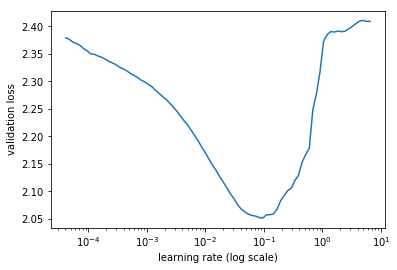

In [7]:
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4)
learn.clip = 1e-1
learn.sched.plot(n_skip_end=1)

In [8]:
%time learn.fit(1.5, 1, wds=1e-4, cycle_len=30, use_clr_beta=(15, 10, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                 
    0      1.600993   1.441529   0.4754    
    1      1.188086   1.41085    0.5334                   
    2      0.910884   1.36183    0.5558                    
    4      0.611622   0.841227   0.7221                    
    5      0.552191   0.764714   0.7504                    
    6      0.503751   0.737051   0.7511                    
    7      0.460971   0.653494   0.7825                    
    8      0.429952   1.264751   0.6541                    
    9      0.397564   0.723189   0.7511                    
    10     0.37606    0.683567   0.7782                    
    11     0.360873   0.577565   0.7981                    
    12     0.341871   0.695879   0.7759                    
    13     0.323827   0.59713    0.798                     
    14     0.304483   0.473728   0.8451                    
    15     0.28388    0.555944   0.816                     
    16     0.257587   0.87107    0.7456                   

[array([0.20169]), 0.9419000004768372]

In [9]:
get_TTA_accuracy(learn)

0.948

## With tweaks for training locally on a 1080ti 

I run the training 3 times just to make sure we hit 94% accuracy with some degree of reliability.

In [10]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.169543   1.263701   0.5503    
    1      0.908752   1.154146   0.6011                      
    2      0.771108   0.912175   0.6869                      
    3      0.676908   0.793713   0.7236                      
    4      0.628075   0.736298   0.7481                      
    5      0.585728   0.812324   0.7084                      
    6      0.556467   0.958268   0.682                       
    7      0.553127   0.802786   0.7342                      
    8      0.537662   0.661663   0.7748                      
    9      0.503087   0.917536   0.7149                      
    10     0.482562   0.680255   0.7792                      
    11     0.448644   0.824123   0.7396                      
    12     0.420774   0.750203   0.7668                      
    13     0.393915   0.505999   0.8259                      
    14     0.365846   0.544087   0.8179                      
    15     0.328399   0.416

In [11]:
get_TTA_accuracy(learn)

0.9431

In [12]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.208857   1.557635   0.5105    
    1      0.928309   1.364705   0.5856                      
    2      0.7586     0.78556    0.7276                      
    3      0.671309   0.965542   0.6779                      
    4      0.629488   0.748223   0.7472                      
    5      0.567147   0.801228   0.7312                      
    6      0.555923   1.104574   0.651                       
    7      0.55037    0.768465   0.7412                      
    8      0.52509    1.087103   0.668                       
    9      0.510132   0.814182   0.7428                      
    10     0.474      1.115937   0.6912                      
    11     0.464195   0.84923    0.7256                      
    12     0.439663   0.473122   0.8399                      
    13     0.405162   0.6486     0.7843                      
    14     0.365501   0.469936   0.841                       
    15     0.322079   0.389

In [13]:
get_TTA_accuracy(learn)

0.9402

In [14]:
%%time
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.215059   1.240503   0.5669    
    1      0.899173   1.022645   0.6619                      
    2      0.75076    0.80045    0.7308                      
    3      0.676683   0.960973   0.6804                      
    4      0.604371   0.844541   0.7308                      
    5      0.579993   0.923703   0.6962                      
    6      0.549273   0.74115    0.7459                      
    7      0.538123   0.842362   0.718                       
    8      0.52504    1.040526   0.6702                      
    9      0.500089   0.84092    0.731                       
    10     0.464431   0.546925   0.819                       
    11     0.444645   0.758121   0.7587                      
    12     0.422681   0.573507   0.8074                      
    13     0.396939   0.584204   0.8102                      
    14     0.377264   0.599833   0.8012                      
    15     0.312021   0.511

In [15]:
get_TTA_accuracy(learn)

0.9416

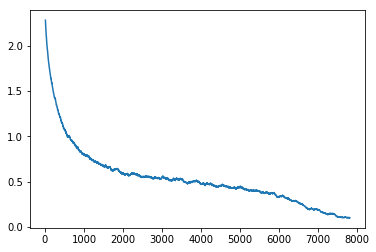

In [16]:
learn.sched.plot_loss()

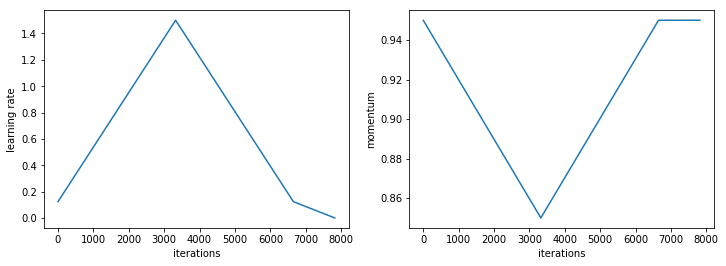

In [17]:
learn.sched.plot_lr()